In [5]:
from __future__ import print_function

# from miscc.config import cfg, cfg_from_file
# from datasets import TextDataset
from trainer import JoImTeR as trainer

import os
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
import argparse
import numpy as np
import pandas as pd
from misc.config import Config
cfg = Config()

import torch
import torchvision.transforms as transforms

In [2]:
class parse_args():
    description='JoImTeR'
    cfg_file='cfg/bird_attn2.yml'
    gpu_id=0
    data_dir=''
    manualSeed=1

In [4]:
args = parse_args()

if args.gpu_id != -1:
    cfg.GPU_ID = args.gpu_id
else:
    cfg.CUDA = False

if args.data_dir != '':
    cfg.DATA_DIR = args.data_dir

if args.manualSeed is None:
    args.manualSeed = random.randint(1, 10000)
random.seed(args.manualSeed)
np.random.seed(args.manualSeed)
torch.manual_seed(args.manualSeed)
if cfg.CUDA:
    torch.cuda.manual_seed_all(args.manualSeed)

# Dataset

In [7]:
path=os.getcwd() #Get the path
path

'/home/ipmi/code'

In [18]:
proj_ds=pd.read_csv('../data/ChestXRay/dataset/indiana_projections.csv')
repo_ds=pd.read_csv('../data/ChestXRay/dataset/indiana_reports.csv')

display(proj_ds.head(5),proj_ds.shape)
display(repo_ds.sort_values(by='uid').head(5),repo_ds.shape)

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


(7466, 3)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XXXX. Pain to R back, R elbow and R rib XXXX, no previous heart or lung hx, non-XXXX, no hx ca",NaN,NaN,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous Emphysema;Pulmonary Fibrosis/interstitial;Cicatrix/lung/upper lobe/left;Opacity/lung/apex/left/irregular;Opacity/lung/upper lobe/right/streaky;Opacity/pulmonary alveoli;Opacity/lung/bilateral/interstitial/diffuse","Pulmonary Disease, Chronic Obstructive;Bullous Emphysema;Pulmonary Fibrosis;Cicatrix;Opacity;Opacity;Opacity;Opacity","PA and lateral views of the chest XXXX, XXXX at XXXX hours",XXXX-year-old XXXX with XXXX.,None available,"There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.","1. Bullous emphysema and interstitial fibrosis. 2. Probably scarring in the left apex, although difficult to exclude a cavitary lesion. 3. Opacities in the bilateral upper lobes could represent scarring, however the absence of comparison exam, recommend short interval followup radiograph or CT thorax to document resolution."
4,5,Osteophyte/thoracic vertebrae/multiple/small;Thickening/pleura/apex/bilateral;Lung/hyperdistention/mild,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-spine osteophytes. There is biapical pleural thickening, unchanged from prior. Mildly hyperexpanded lungs.",No acute cardiopulmonary abnormality.


(3851, 8)

In [21]:
repo_ds[repo_ds['impression'].isna()]

,uid,MeSH,Problems,image,indication,comparison,findings,impression
15,16,normal,normal,Xray Chest PA and Lateral,NaN,NaN,NaN,NaN
314,326,normal,normal,PA and lateral chest,XXXX-year-old female with XXXX for one XXXX,"XXXX, XXXX",The lungs are clear. Heart size and mediastinal contours are normal. No osseous abnormalities.,NaN
596,614,normal,normal,Xray Chest PA and Lateral,NaN,NaN,NaN,NaN
654,673,normal,normal,Xray Chest PA and Lateral,NaN,NaN,NaN,NaN
798,824,Calcified Granuloma;Thoracic Vertebrae/degenerative,Calcified Granuloma;Thoracic Vertebrae,Xray Chest PA and Lateral,"XXXX-year-old female, tobacco use, preop.",None,There are no focal areas of consolidation. No pleural effusions. No pneumothorax. Heart size within normal limits. Calcified granulomas. Degenerative changes thoracic spine.,NaN
864,894,normal,normal,Xray Chest PA and Lateral,NaN,NaN,NaN,NaN
1049,1084,normal,normal,"CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",SOB WITH XXXX,None.,"The trachea is midline. The cardiomediastinal silhouette is normal. The lungs are clear, without evidence of acute infiltrate or effusion. There is no pneumothorax. The visualized bony structures reveal no acute abnormalities.",NaN
1100,1137,normal,normal,Xray Chest PA and Lateral,NaN,NaN,NaN,NaN
1105,1142,normal,normal,Xray Chest PA and Lateral,NaN,NaN,NaN,NaN
1110,1147,normal,normal,Xray Chest PA and Lateral,NaN,NaN,NaN,NaN


In [28]:
c_repo_ds = repo_ds.dropna(subset=['findings','impression'],how='all')
display(c_repo_ds.head())
c_repo_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XXXX. Pain to R back, R elbow and R rib XXXX, no previous heart or lung hx, non-XXXX, no hx ca",NaN,NaN,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous Emphysema;Pulmonary Fibrosis/interstitial;Cicatrix/lung/upper lobe/left;Opacity/lung/apex/left/irregular;Opacity/lung/upper lobe/right/streaky;Opacity/pulmonary alveoli;Opacity/lung/bilateral/interstitial/diffuse","Pulmonary Disease, Chronic Obstructive;Bullous Emphysema;Pulmonary Fibrosis;Cicatrix;Opacity;Opacity;Opacity;Opacity","PA and lateral views of the chest XXXX, XXXX at XXXX hours",XXXX-year-old XXXX with XXXX.,None available,"There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.","1. Bullous emphysema and interstitial fibrosis. 2. Probably scarring in the left apex, although difficult to exclude a cavitary lesion. 3. Opacities in the bilateral upper lobes could represent scarring, however the absence of comparison exam, recommend short interval followup radiograph or CT thorax to document resolution."
4,5,Osteophyte/thoracic vertebrae/multiple/small;Thickening/pleura/apex/bilateral;Lung/hyperdistention/mild,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-spine osteophytes. There is biapical pleural thickening, unchanged from prior. Mildly hyperexpanded lungs.",No acute cardiopulmonary abnormality.


(3826, 8)

In [ ]:
c_repo_ds[c_repo_ds['Problems']!='normal']

In [30]:
merged_ds = pd.merge(left=c_repo_ds,right=proj_ds,on='uid',how='inner')
display(merged_ds.head())
merged_ds.shape

,uid,MeSH,Problems,image,indication,comparison,findings,impression,filename,projection
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,Frontal
1,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,Normal chest x-XXXX.,1_IM-0001-3001.dcm.png,Lateral
2,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Frontal
3,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.,No acute pulmonary findings.,2_IM-0652-2001.dcm.png,Lateral
4,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XXXX. Pain to R back, R elbow and R rib XXXX, no previous heart or lung hx, non-XXXX, no hx ca",NaN,NaN,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.",3_IM-1384-1001.dcm.png,Frontal


(7426, 10)

In [32]:
pd.options.display.max_colwidth=0
frontal_ds = merged_ds[merged_ds['projection']=='Frontal']

In [40]:
data_df = frontal_ds[['uid','findings','impression','filename']]
data_df.shape

(3794, 4)

In [64]:
text = []
for i in range(data_df.shape[0]):
    fin = str(data_df.iloc[i]['findings'])
    imp = data_df.iloc[i]['impression']
    if len(fin)>0 and fin!='nan':
        text.append(fin)
    else:
        text.append(imp)

In [67]:
data_df['text'] = text


,uid,findings,impression,filename,text
0,1,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,Normal chest x-XXXX.,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.
2,2,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.,No acute pulmonary findings.,2_IM-0652-1001.dcm.png,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.
4,3,NaN,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.",3_IM-1384-1001.dcm.png,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified."
6,4,"There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.","1. Bullous emphysema and interstitial fibrosis. 2. Probably scarring in the left apex, although difficult to exclude a cavitary lesion. 3. Opacities in the bilateral upper lobes could represent scarring, however the absence of comparison exam, recommend short interval followup radiograph or CT thorax to document resolution.",4_IM-2050-1001.dcm.png,"There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion."
8,5,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-spine osteophytes. There is biapical pleural thickening, unchanged from prior. Mildly hyperexpanded lungs.",No acute cardiopulmonary abnormality.,5_IM-2117-1003002.dcm.png,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-spine osteophytes. There is biapical pleural thickening, unchanged from prior. Mildly hyperexpanded lungs."
...,...,...,...,...,...
7416,3995,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are mildly hyperinflated with flattening of the diaphragms and expansion of the retrosternal clear space. Compared with prior exam, there has been interval resolution of previously demonstrated bibasilar infiltrates. There is minimal XXXX scarring or atelectasis in the right midlung. There is no XXXX focal airspace disease. There is no pneumothorax or pleural effusion. There are no acute bony findings.",1. Interval resolution of bibasilar airspace disease. 2. Hyperinflation with chronic changes of emphysema. .,3995_IM-2046-1001.dcm.png,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are mildly hyperinflated with flattening of

In [69]:
clean_data_df = data_df[['uid','filename','text']]

In [ ]:
def cleaner(t):
    if
    return cleanedtext

In [89]:
cleantext = []
for i in range(clean_data_df.shape[0]):
    text = clean_data_df.iloc[i]['text']
    cleantext.append(re.sub('(xx)+|(x-)','',text.lower()))

In [90]:
clean_data_df['cleantext'] = cleantext
clean_data_df

,uid,filename,text,cleantext
0,1,1_IM-0001-4001.dcm.png,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion. there is no evidence of pneumothorax.
2,2,2_IM-0652-1001.dcm.png,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.,borderline cardiomegaly. midline sternotomy . enlarged pulmonary arteries. clear lungs. inferior .
4,3,3_IM-1384-1001.dcm.png,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.","no displaced rib fractures, pneumothorax, or pleural effusion identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary abnormality identified."
6,4,4_IM-2050-1001.dcm.png,"There are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. There are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.There are streaky opacities in the right upper lobe, XXXX scarring. The cardiomediastinal silhouette is normal in size and contour. There is no pneumothorax or large pleural effusion.","there are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. there are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.there are streaky opacities in the right upper lobe, scarring. the cardiomediastinal silhouette is normal in size and contour. there is no pneumothorax or large pleural effusion."
8,5,5_IM-2117-1003002.dcm.png,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. Cholecystectomy clips are present. Small T-spine osteophytes. There is biapical pleural thickening, unchanged from prior. Mildly hyperexpanded lungs.","the cardiomediastinal silhouette and pulmonary vasculature are within normal limits. there is no pneumothorax or pleural effusion. there are no focal areas of consolidation. cholecystectomy clips are present. small t-spine osteophytes. there is biapical pleural thickening, unchanged from prior. mildly hyperexpanded lungs."
...,...,...,...,...
7416,3995,3995_IM-2046-1001.dcm.png,"The cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. The lungs are mildly hyperinflated with flattening of the diaphragms and expansion of the retrosternal clear space. Compared with prior exam, there has been interval resolution of previously demonstrated bibasilar infiltrates. There is minimal XXXX scarring or atelectasis in the right midlung. There is no XXXX focal airspace disease. There is no pneumothorax or pleural effusion. There are no acute bony findings.","the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. the lungs are mildly hyperinflated with flattening of the diaphragms and expansion of the retrosternal clear space. compared with prior exam, there has been interval resolution of previously demonstrated bibasilar infiltrates. there is minimal scarring or atelectasis in the right midlung. there is no focal airspace disease. there is no pneumothorax or pleural effusion. there are no acute bony findings."
7418,3996,3996_IM-2047-1001.dcm.png,The lungs are clear. Heart size is normal. No pneumothorax. There are endplate changes in the spine.,the lungs are clear. heart size is normal. no pneumothorax. there are endplate c

In [100]:
clean_data_df = clean_data_df.drop(columns=['text'])
clean_data_df.columns = ['uid','filename','text']
clean_data_df

,uid,filename,text
0,1,1_IM-0001-4001.dcm.png,the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no of a pleural effusion. there is no evidence of pneumothorax.
2,2,2_IM-0652-1001.dcm.png,borderline cardiomegaly. midline sternotomy . enlarged pulmonary arteries. clear lungs. inferior .
4,3,3_IM-1384-1001.dcm.png,"no displaced rib fractures, pneumothorax, or pleural effusion identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary abnormality identified."
6,4,4_IM-2050-1001.dcm.png,"there are diffuse bilateral interstitial and alveolar opacities consistent with chronic obstructive lung disease and bullous emphysema. there are irregular opacities in the left lung apex, that could represent a cavitary lesion in the left lung apex.there are streaky opacities in the right upper lobe, scarring. the cardiomediastinal silhouette is normal in size and contour. there is no pneumothorax or large pleural effusion."
8,5,5_IM-2117-1003002.dcm.png,"the cardiomediastinal silhouette and pulmonary vasculature are within normal limits. there is no pneumothorax or pleural effusion. there are no focal areas of consolidation. cholecystectomy clips are present. small t-spine osteophytes. there is biapical pleural thickening, unchanged from prior. mildly hyperexpanded lungs."
...,...,...,...
7416,3995,3995_IM-2046-1001.dcm.png,"the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. the lungs are mildly hyperinflated with flattening of the diaphragms and expansion of the retrosternal clear space. compared with prior exam, there has been interval resolution of previously demonstrated bibasilar infiltrates. there is minimal scarring or atelectasis in the right midlung. there is no focal airspace disease. there is no pneumothorax or pleural effusion. there are no acute bony findings."
7418,3996,3996_IM-2047-1001.dcm.png,the lungs are clear. heart size is normal. no pneumothorax. there are endplate changes in the spine.
7420,3997,3997_IM-2048-1001.dcm.png,"heart size within normal limits. small, nodular opacity in the right upper lobe. this does not look like an acute infiltrate, and more represents a granuloma. no pneumothorax or effusions."
7422,3998,3998_IM-2048-1001.dcm.png,heart size is normal and the lungs are clear.


In [109]:
uids = clean_data_df.uid.unique()
np.random.shuffle(uids)

In [113]:
len(uids)

3666

In [121]:
test_uids = uids[:300]
val_uids = uids[300:500]
train_uids = uids[500:]
train_uids.shape, val_uids.shape, test_uids.shape

((3166,), (200,), (300,))

In [122]:
split = [] # 0, 1, 2 = train, val, test
for i in range(clean_data_df.shape[0]):
    uid = clean_data_df.iloc[i]['uid']
    if uid in train_uids:
        split.append(0)
    elif uid in val_uids:
        split.append(1)
    else:
        split.append(2)

In [123]:
clean_data_df['split'] = split

In [131]:
clean_data_df[clean_data_df['split']==1].shape

(210, 4)

In [136]:
clean_data_df.uid.value_counts()

1303    4
3307    3
3965    3
2280    3
1976    3
       ..
1278    1
1274    1
3319    1
1270    1
2049    1
Name: uid, Length: 3666, dtype: int64

In [137]:
clean_data_df[clean_data_df['uid']==1303]

,uid,filename,text,split
2411,1303,1303_IM-0199-1001-0001.dcm.png,"in the interval, a 3 cm uncalcified mass has developed in the posterior segment of the right upper lobe. in addition, on the pa view, an 8 mm opacity is adjacent to the left of the heart. this opacity cannot be well identified on the lateral view. it may be artifactual, but another mass on the left cannot be excluded. mediastinum is normal with no evidence for adenopathy. heart size normal. note of an unchanged hiatal hernia.",1
2412,1303,1303_IM-0199-1001-0002.dcm.png,"in the interval, a 3 cm uncalcified mass has developed in the posterior segment of the right upper lobe. in addition, on the pa view, an 8 mm opacity is adjacent to the left of the heart. this opacity cannot be well identified on the lateral view. it may be artifactual, but another mass on the left cannot be excluded. mediastinum is normal with no evidence for adenopathy. heart size normal. note of an unchanged hiatal hernia.",1
2413,1303,1303_IM-0199-2001-0001.dcm.png,"in the interval, a 3 cm uncalcified mass has developed in the posterior segment of the right upper lobe. in addition, on the pa view, an 8 mm opacity is adjacent to the left of the heart. this opacity cannot be well identified on the lateral view. it may be artifactual, but another mass on the left cannot be excluded. mediastinum is normal with no evidence for adenopathy. heart size normal. note of an unchanged hiatal hernia.",1
2414,1303,1303_IM-0199-2001-0003.dcm.png,"in the interval, a 3 cm uncalcified mass has developed in the posterior segment of the right upper lobe. in addition, on the pa view, an 8 mm opacity is adjacent to the left of the heart. this opacity cannot be well identified on the lateral view. it may be artifactual, but another mass on the left cannot be excluded. mediastinum is normal with no evidence for adenopathy. heart size normal. note of an unchanged hiatal hernia.",1


In [151]:
data_dict = {}
for i in range(clean_data_df.shape[0]):
    uid = clean_data_df.iloc[i]['uid']
    filenames=[clean_data_df.iloc[i]['filename']]
    split=clean_data_df.iloc[i]['split']
    text=clean_data_df.iloc[i]['text']
    if uid not in data_dict:
        data_dict[clean_data_df.iloc[i]['uid']]={'filenames':filenames,'text':text,'split':split}
    else:
        data_dict[clean_data_df.iloc[i]['uid']]['filenames'].append(filenames[0])

In [152]:
id_dict={}
id_dict['train_uids']=train_uids
id_dict['val_uids']=val_uids
id_dict['test_uids']=test_uids

In [153]:
dataset={}
dataset['data_dict']=data_dict
dataset['data_split']=id_dict

In [146]:
import pickle

In [154]:
# with open('../data/ChestXRay/dataset/cleaned_dataset.pickle','wb') as f:
#     pickle.dump(dataset,f)

# Dataloader 

In [157]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torchvision as tv

import os,sys
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import spacy
import scispacy
from tqdm import tqdm 
from nltk.tokenize import RegexpTokenizer
from transformers import BertTokenizer


In [158]:
nlp = spacy.load('en_core_sci_md')

In [159]:
with open('../data/ChestXRay/dataset/cleaned_dataset.pickle','rb') as f:
    dataset = pickle.load(f)
dataset.keys()

dict_keys(['data_dict', 'data_split'])

In [193]:

# vocab='allenai/scibert_scivocab_uncased'
vocab = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = BertTokenizer.from_pretrained(vocab, do_lower=True)

def remove_whitespace(line):
    return str(" ".join(line.split()).strip())

def list_to_string(sentence):
    return " ".join(sentence)

def normalize_report(row):
    report = row
    report_sentences = nlp(report)
    new_report_sentences = []
    for sentence in report_sentences.sents:
        index_to_keep_dict = {} # index: {keep that token or not, replace_with}
        for index in range(0, len(sentence)):
            token = sentence[index]
            if index < len(sentence) - 1:
                next_token = sentence[index + 1]
                if token.is_punct and next_token.is_punct and token.text.strip() == next_token.text.strip():
                    # when it is the same type of punctuation
                    index_to_keep_dict[index] = {'keep': False, 'replace_with': None}
                    continue
            if token.like_num:
                index_to_keep_dict[index] = {'keep': True, 'replace_with': 'NUMBER'}
            else:
                index_to_keep_dict[index] = {'keep': True, 'replace_with': None}
        # generate a new sentence based on this replacement
        new_sentence = []
        for index in range(0, len(sentence)):
            token = sentence[index]
            if not index_to_keep_dict[index]['keep']:
                continue # don't append when there is a double punctuation happening
            if index_to_keep_dict[index]['replace_with'] is not None:
                new_sentence.append(index_to_keep_dict[index]['replace_with'])
                continue
            new_sentence.append(token.text)
        s = list_to_string(new_sentence).strip()
        s = s.replace('DEID', '')
        s = remove_whitespace(s)
        new_report_sentences.append(s)
    return {'sentences': ' '.join(new_report_sentences)}

In [194]:
# print(dataset['data_dict'][3]['text'])
# sents = normalize_report(dataset['data_dict'][3]['text'])
# sents

In [195]:
token_dict = {}
counter=0
tokenizer = RegexpTokenizer(r'\w+')

for uid in tqdm(dataset['data_dict']):
    text = dataset['data_dict'][uid]['text']
    tokens = tokenizer.tokenize(normalize_report(text)['sentences'].lower())
    for token in tokens:
        if str(token) not in token_dict:
            token_dict[str(token)]=1
        else:
            token_dict[str(token)]+=1

100%|██████████| 3666/3666 [00:31<00:00, 114.88it/s]


In [237]:
token_id_list = []
counter=0
tokenizer = RegexpTokenizer(r'\w+')

for uid in tqdm(dataset['data_dict']):
    text = dataset['data_dict'][uid]['text']
    tokens = tokenizer.tokenize(normalize_report(text)['sentences'].lower())
    token_ids = [word2idx['[CLS]']]+[word2idx[x] if x in word2idx else word2idx['[UNK]'] for x in tokens]+[word2idx['[SEP]']]
    token_id_list.append(token_ids)

100%|██████████| 3666/3666 [00:31<00:00, 115.37it/s]


In [260]:
temp_df = pd.DataFrame(dataset['data_dict']).T
temp_df['token_ids'] = token_id_list

In [261]:
temp_df


,filenames,text,split,token_ids
1,[1_IM-0001-4001.dcm.png],the cardiac silhouette and mediastinum size ar...,0,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
2,[2_IM-0652-1001.dcm.png],borderline cardiomegaly. midline sternotomy . ...,0,"[1, 27, 28, 29, 30, 31, 17, 32, 33, 34, 35, 2]"
3,[3_IM-1384-1001.dcm.png],"no displaced rib fractures, pneumothorax, or p...",0,"[1, 16, 36, 37, 38, 26, 39, 23, 24, 40, 41, 42..."
4,[4_IM-2050-1001.dcm.png],there are diffuse bilateral interstitial and a...,0,"[1, 14, 10, 48, 49, 50, 7, 51, 52, 53, 54, 55,..."
5,[5_IM-2117-1003002.dcm.png],the cardiomediastinal silhouette and pulmonary...,0,"[1, 4, 75, 6, 7, 17, 77, 10, 11, 12, 13, 14, 1..."
...,...,...,...,...
3995,[3995_IM-2046-1001.dcm.png],the cardiomediastinal silhouette and pulmonary...,2,"[1, 4, 75, 6, 7, 17, 77, 10, 11, 12, 13, 62, 9..."
3996,[3996_IM-2047-1001.dcm.png],the lungs are clear. heart size is normal. no ...,0,"[1, 4, 34, 10, 33, 93, 9, 15, 12, 16, 26, 14, ..."
3997,[3997_IM-2048-1001.dcm.png],"heart size within normal limits. small, nodula...",0,"[1, 93, 9, 11, 12, 13, 82, 421, 96, 62, 4, 71,..."
3998,[3998_IM-2048-1001.dcm.png],heart size is normal and the lungs are clear.,0,"[1, 93, 9, 15, 12, 7, 4, 34, 10, 33, 2]"


In [262]:
temp_df.T.to_dict()

{1: {'filenames': ['1_IM-0001-4001.dcm.png'],
  'text': 'the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no  of a pleural effusion. there is no evidence of pneumothorax.',
  'split': 0,
  'token_ids': [1,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   14,
   15,
   16,
   19,
   20,
   14,
   10,
   16,
   21,
   22,
   23,
   24,
   14,
   15,
   16,
   25,
   21,
   26,
   2]},
 2: {'filenames': ['2_IM-0652-1001.dcm.png'],
  'text': 'borderline cardiomegaly. midline sternotomy . enlarged pulmonary arteries. clear lungs. inferior   .',
  'split': 0,
  'token_ids': [1, 27, 28, 29, 30, 31, 17, 32, 33, 34, 35, 2]},
 3: {'filenames': ['3_IM-1384-1001.dcm.png'],
  'text': 'no displaced rib fractures, pneumothorax, or pleural effusion identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary a

In [244]:
' '.join([idx2word[x] for x in temp_df.iloc[-1]['token_ids']])

'[CLS] the cardiac silhouette is normal in size and configuration the mediastinum and perihilar structures appear unremarkable the lungs appear clear the osseous structures are within normal limits [SEP]'

In [201]:
pd.options.display.max_rows = 600
df_vocab = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
df_vocab.columns = ['word','frequency']
df_useful_vocab = df_vocab[df_vocab['frequency']>1]['word'].values

In [207]:
df_iu_vocab = pd.DataFrame()
df_iu_vocab['words'] = ['[PAD]', '[CLS]', '[SEP]','[UNK]']+list(df_useful_vocab)
df_iu_vocab['word_ids'] = list(range(len( ['[PAD]', '[CLS]', '[SEP]','[UNK]']+list(df_useful_vocab))))
df_iu_vocab

,words,word_ids
0,[PAD],0
1,[CLS],1
2,[SEP],2
3,[UNK],3
4,the,4
...,...,...
1191,origin,1191
1192,thought,1192
1193,laryngeal,1193
1194,imaged,1194


In [210]:
idx2word = df_iu_vocab.to_dict()['words']

In [218]:
word2idx = {}
for k,v in idx2word.items():
    word2idx[v]=k

In [266]:
with open('../data/ChestXRay/dataset/cleaned_dataset.pickle','rb') as f:
    temp = pickle.load(f)

In [269]:
temp['data_dict'][1303]

['[CLS]',
 'in',
 'the',
 'interval',
 'a',
 'number',
 'cm',
 'uncalcified',
 'mass',
 'has',
 'developed',
 'in',
 'the',
 'posterior',
 'segment',
 'of',
 'the',
 'right',
 'upper',
 'lobe',
 'in',
 'addition',
 'on',
 'the',
 'pa',
 'view',
 'an',
 'number',
 'mm',
 'opacity',
 'is',
 'adjacent',
 'to',
 'the',
 'left',
 'of',
 'the',
 'heart',
 'this',
 'opacity',
 'can',
 'not',
 'be',
 'well',
 'identified',
 'on',
 'the',
 'lateral',
 'view',
 'it',
 'may',
 'be',
 'artifactual',
 'but',
 'another',
 'mass',
 'on',
 'the',
 'left',
 'can',
 'not',
 'be',
 'excluded',
 'mediastinum',
 'is',
 'normal',
 'with',
 'no',
 'evidence',
 'for',
 'adenopathy',
 'heart',
 'size',
 'normal',
 'note',
 'of',
 'an',
 'unchanged',
 'hiatal',
 'hernia',
 '[SEP]']

In [265]:
# with open('../data/ChestXRay/dataset/cleaned_dataset.pickle','wb') as f:
#     pickle.dump(temp,f)

In [181]:
example_sent = normalize_report(dataset['data_dict'][1]['text'])['sentences']
example_sent

'the cardiac silhouette and mediastinum size are within normal limits  there is no pulmonary edema  there is no focal consolidation  there are no of a pleural effusion  there is no evidence of pneumothorax '

In [182]:
results = tokenizer.encode_plus(example_sent, max_length=128, padding='max_length', 
                                    return_attention_mask=True, return_token_type_ids=False, truncation=True)
np.array(results['attention_mask'])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [187]:
tokenizer.convert_tokens_to_ids(['##st'])

[2050]

In [48]:
pd.DataFrame.from_dict(token_dict,orient='index')

,0
the,6210
cardiac,388
silhouette,1041
and,2913
media,1524
...,...
stabilization,1
we,1
maximum,1
expansion,1


In [44]:
pd.DataFrame.from_dict(token_dict,orient='index')

,0
the,6210
cardiac,388
silhouette,977
and,2913
mediastinum,573
...,...
stabilization,1
we,1
maximum,1
expansion,1


In [41]:
pd.DataFrame.from_dict(token_dict,orient='index')

,0
the,6208
cardiac,388
silhouette,977
and,2899
mediastinum,572
...,...
we,1
maximum,1
effusion/hemothorax,1
expansion,1


In [134]:
MAX_DIM = 2048

train_transform = tv.transforms.Compose([
    tv.transforms.RandomCrop(MAX_DIM),
#     tv.transforms.ColorJitter(brightness=[0.5, 1.3], contrast=[
#                               0.8, 1.5], saturation=[0.2, 1.5]),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(0.5, 0.5),
])

val_transform = tv.transforms.Compose([
    tv.transforms.CenterCrop(MAX_DIM),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(0.5, 0.5)
])

class IUDataset(Dataset):
    def __init__(self, root, dataset, max_length, transform=train_transform, mode='train'):
        super().__init__()

        self.root = root #save dir
        self.transform = transform
        self.mode = mode
        vocab='allenai/scibert_scivocab_uncased'
        self.tokenizer = BertTokenizer.from_pretrained(vocab, do_lower=True)

        self.datadict = dataset['data_dict'] # uid: {text:text, filenames:[filename]}
        if self.mode == 'train':
            self.keys = dataset['data_split']['train_uids'] # uid list
        elif self.mode == 'val':
            self.keys = dataset['data_split']['val_uids'] # uid list
        elif self.mode == 'test':
            self.keys = dataset['data_split']['test_uids'] # uid list

        self.max_length = max_length + 1

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        uid = self.keys[idx]
        
        image_id = np.random.choice(self.datadict[uid]['filenames'])# get one file name randomly
        image = Image.open(os.path.join(self.root, image_id))
        if self.transform:
            image = self.transform(image)

        caption = self.datadict[uid]['text']
        caption = normalize_report(caption)['sentences']
        caption_encoded = self.tokenizer.encode_plus(
                                    caption, max_length=self.max_length, padding='max_length', 
                                    return_attention_mask=True, return_token_type_ids=False, truncation=True)

        caption = np.array(caption_encoded['input_ids'])
        cap_mask = np.array(caption_encoded['attention_mask']).astype(bool)

        return image, caption, cap_mask

def build_dataset(mode='train'):
    data_dir = '../data/ChestXRay/dataset/'
    img_dir = os.path.join(data_dir, 'images', 'images_normalized')
    with open('../data/ChestXRay/dataset/cleaned_dataset.pickle','rb') as f:
        dataset = pickle.load(f)
    if mode == 'train':
        data = IUDataset(img_dir, dataset, 
                               max_length=128, mode=mode, 
                               transform=train_transform)
        return data

    elif mode == 'val':
        data = IUDataset(img_dir, dataset, 
                               max_length=128, mode=mode, 
                               transform=val_transform)
        return data
    
    elif mode == 'test':
        data = IUDataset(img_dir, dataset, 
                               max_length=128, mode=mode, 
                               transform=val_transform)
        return data

    else:
        raise NotImplementedError(f"{mode} not supported")

In [135]:
data_set = build_dataset('train')
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=8, drop_last=True,
                    shuffle=True, num_workers=0)

In [136]:
it = iter(train_loader)

In [137]:
img, txt, mask = it.next()

In [280]:
print(img.shape, txt.shape, mask.shape)

torch.Size([8, 1, 2048, 2048]) torch.Size([8, 129]) torch.Size([8, 129])


(2048, 2048)


AttributeError: 'RegexpTokenizer' object has no attribute 'decode'

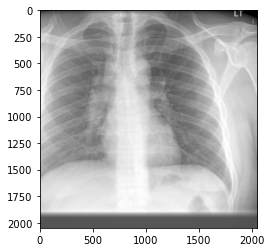

In [281]:
from matplotlib import pyplot as plt
i = 0
im = np.squeeze(img[i].numpy(),0)
print(im.shape)
plt.imshow(im, cmap='gray')
print(idx2word[x] for x in txt)
print(mask[i].numpy())


In [122]:
np.random.choice([0,1,2,3,4])

1

In [123]:
im = Image.open('../data/ChestXRay/dataset/images/images_normalized/10_IM-0002-1001.dcm.png')

In [124]:
im.size

(2048, 2496)

In [156]:
mask.sum(-1)

tensor([45, 58, 35, 35, 39, 23, 67, 26])

In [333]:
%load_ext autoreload

In [614]:

import dataset
import importlib
importlib.reload(dataset)

<module 'dataset' from '/home/ipmi/code/dataset.py'>

In [530]:
from misc.config import Config
cfg = Config()

In [531]:
data_set = dataset.build_dataset('train',cfg=cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=8, drop_last=True,
                    shuffle=False, num_workers=0)
it = iter(train_loader)

In [532]:
imgs,caps,masks,uids,cap_lens=it.next()

-1.0 1.0


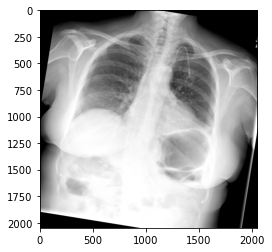

In [533]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
print(im.min(),im.max())
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

-0.12156862 0.45098042


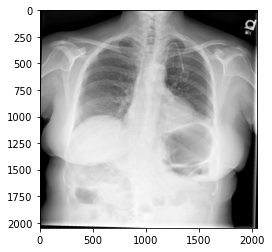

In [528]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
print(im.min(),im.max())
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

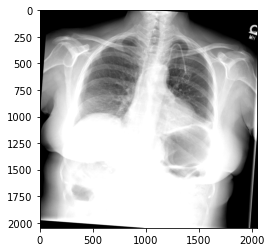

In [514]:
i = 3
im = np.squeeze(imgs[i].numpy(),0)
# print(im.shape)
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

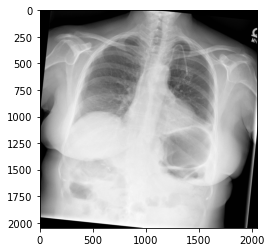

In [519]:
from matplotlib import pyplot as plt
i = 3
im = np.squeeze(imgs[i].numpy(),0)
# print(im.shape)
plt.imshow((im + 1)/(2), cmap='gray')
# print(' '.join([idx2word[x] for x in caps[i].numpy()]))
# print(masks[i].numpy())
# print(uids[i])
# print(dataset['data_dict'][uids[i].tolist()])

In [299]:
dataset['data_dict'][uids[i].tolist()]

{'filenames': ['19_IM-0583-1001.dcm.png'],
 'text': 'heart size is normal. there is tortuosity of the thoracic aorta, stable compared with prior. no focal airspace disease or effusion. no pleural effusions or pneumothoraces. degenerative changes in the thoracic spine.',
 'split': 0}

In [364]:
import torch.nn as nn
import math
# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        # self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)
        self.globalavg = nn.AdaptiveAvgPool1d(1)
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, mask):

        src = self.encoder(src) * math.sqrt(self.ninp)
        print(src.shape)
        src = self.pos_encoder(src)
        word_feats = self.transformer_encoder(src, mask)  # max_len, batchsize, feats_size
        print('word_feats.shape:',word_feats.shape)
        word_feats = torch.transpose(word_feats, 1, 2)  # max_len, feats_size, batchsize
        print('word_feats.shape:',word_feats.shape)
        sent_feats = self.globalavg(word_feats[:, mask.sum(-1),:])
        print('sent_feats.shape:',sent_feats.shape)
        sent_feats = self.fc(sent_feats)
        return F.log_softmax(output, dim=-1)

In [368]:
imgs,caps,masks,uids=it.next()

In [369]:
# masks = mask
# masks.shape
caps.shape

torch.Size([8, 129])

In [382]:
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false
    In place operation
    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices[0], indices[1]] = maskval
################ Transformer: Text Encoder ############
class SelfAttention(nn.Module):
    def __init__(self, k, heads=8, mask=False):
        super().__init__()
        self.k, self.heads = k, heads
        # These compute the queries, keys and values for all 
        # heads (as a single concatenated vector)
        self.tokeys    = nn.Linear(k, k * heads, bias=False)
        self.toqueries = nn.Linear(k, k * heads, bias=False)
        self.tovalues  = nn.Linear(k, k * heads, bias=False)

        # This unifies the outputs of the different heads into 
        # a single k-vector
        self.unifyheads = nn.Linear(heads * k, k)
    def forward(self, x, mask):
        b, t, k = x.size()
        h = self.heads

        queries = self.toqueries(x).view(b, t, h, k)
        keys    = self.tokeys(x)   .view(b, t, h, k)
        values  = self.tovalues(x) .view(b, t, h, k)
        
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
        values = values.transpose(1, 2).contiguous().view(b * h, t, k)
        
        queries = queries / (k ** (1/4))
        keys    = keys / (k ** (1/4))

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))
        # - dot has size (b*h, t, t) containing raw weights

        
        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)
        
        dot = F.softmax(dot, dim=2) 
        # - dot now contains row-wise normalized weights
        
        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, k)
        
        out = out.transpose(1, 2).contiguous().view(b, t, h * k)
        return self.unifyheads(out)

class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0, wide=True):
        super().__init__()
        self.attention = SelfAttention(k=emb, heads=heads)        
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )
        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x
    
    
class TEXT_TRANSFORMER_ENCODER(nn.Module):
    def __init__(self, emb, heads, depth, seq_length, num_tokens, dropout=0.2, wide=False):
        super().__init__()

        self.num_tokens = num_tokens
        self.wemb_linear  = nn.Linear(768, emb, bias=False)
        self.token_embedding = nn.Embedding(embedding_dim=768, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb
                                 , heads=heads
                                 , seq_length=seq_length
                                 , mask=True
                                 , dropout=dropout
                                 , wide=wide))

        self.tblocks = nn.Sequential(*tblocks)

        self.do = nn.Dropout(dropout)

    def init_embeddings(self, word_embedding, positional_embedding, IsTrainable):
        self.token_embedding.weight.data = word_embedding
        self.token_embedding.weight.requires_grad = IsTrainable
        
        self.pos_embedding.weight.data = positional_embedding
        self.pos_embedding.weight.requires_grad = False
        
        
    def forward(self, x,masks):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        tokens = self.wemb_linear(tokens)
        
        b, t, e = tokens.size()
#         print('b:{0}, t:{1}, e:{2}'.format(b, t, e))
        positions = torch.arange(t)        
        positions = self.pos_embedding(positions)[None, :, :].expand(b, t, e)
        
#         print('positions:',positions.size())
        x = tokens + positions
        x = self.do(x)

#         print('x:',x.size())
        words_emb = self.tblocks(x)
        sent_emb = words_emb.mean(dim=1) # pool over the time dimension
        words_emb = torch.transpose(words_emb,1,2)
        
#         print('words_emb:',words_emb.shape,'sent_emb:',sent_emb.shape)

        return words_emb,sent_emb

In [383]:
transformer_model = TEXT_TRANSFORMER_ENCODER(emb=512,heads=8,depth=4,seq_length=150,num_tokens=data_set.vocab_size)

In [384]:
transformer_model(caps,masks)

TypeError: forward() missing 1 required positional argument: 'mask'

In [386]:
from transformers import BertConfig, BertModel

In [388]:
config = BertConfig(vocab_size=1196, hidden_size=512, num_hidden_layers=3,
                    num_attention_heads=8, intermediate_size=2048, hidden_act='gelu',
                    hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1,
                    max_position_embeddings=512, layer_norm_eps=1e-12,
                    initializer_range=0.02, type_vocab_size=2, pad_token_id=0)

In [391]:
model = BertModel(config,add_pooling_layer=False )

In [392]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(1196, 512, padding_idx=0)
    (position_embeddings): Embedding(512, 512)
    (token_type_embeddings): Embedding(2, 512)
    (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=512, out_features=512, bias=True)
            (key): Linear(in_features=512, out_features=512, bias=True)
            (value): Linear(in_features=512, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=512, out_features=512, bias=True)
            (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )

In [393]:
output = model(input_ids=caps, attention_mask=masks)

In [425]:
m = nn.AdaptiveAvgPool1d(1)
_input = torch.randn(1, 64, 8)
output = m(_input)
output.shape

torch.Size([1, 64, 1])

In [455]:
from transformers import BertPreTrainedModel

class TextEncoder(nn.Module):
    def __init__(self, config):
        super(TextEncoder, self).__init__()
        
        bert = BertModel(config, add_pooling_layer=False)

        self.bert = bert
        self.sent = nn.Linear(512, 512)
        
    def forward(self, x, mask):
        word_feat = self.bert(input_ids=x, attention_mask=mask)[0]
        print(word_feat.shape)
        sent_feat = word_feat[:,0,:]
        sent_feat = self.sent(sent_feat)       
        return sent_feat, word_feat

In [ ]:
word_feat = [129] ['CLS'] ['SEP'] ['PAD'] -> w_loss
word_feat[:,1:,:] -> [8,128,512] 

In [465]:
model = TextEncoder(config)

In [457]:
sent_feats, word_feats = model(caps,masks)

torch.Size([8, 129, 512])


In [466]:
std = model.state_dict()

In [467]:
std.keys()

odict_keys(['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.weigh

In [469]:
std['bert.embeddings.word_embeddings.weight'][0,:] = 0.5
std['bert.embeddings.word_embeddings.weight']

tensor([[ 5.0000e-01,  5.0000e-01,  5.0000e-01,  ...,  5.0000e-01,
          5.0000e-01,  5.0000e-01],
        [-4.2670e-03, -2.2661e-02,  1.3596e-04,  ...,  5.9003e-03,
          4.3368e-02,  9.3442e-03],
        [ 2.3720e-02, -3.3314e-02, -5.4340e-03,  ...,  2.6354e-02,
          2.7614e-02, -7.6545e-03],
        ...,
        [-1.0447e-02, -4.0221e-02,  1.9034e-02,  ...,  5.2405e-03,
          1.2785e-02, -1.9273e-03],
        [ 4.7300e-02, -1.9325e-02, -1.7531e-02,  ...,  1.9294e-02,
         -1.9019e-03, -2.4678e-02],
        [-2.0812e-02, -2.3854e-02,  2.0967e-02,  ..., -5.1604e-03,
          3.7881e-02, -9.3478e-03]])

In [470]:
torch.save(std, 'save/temp.pth')

In [471]:
model2 = TextEncoder(config)

In [472]:
model2.state_dict()['bert.embeddings.word_embeddings.weight'][0]

tensor([ 7.8821e-03, -3.5045e-02,  1.4121e-02,  9.7070e-03, -3.3117e-03,
         9.6901e-03, -9.9555e-03, -1.8174e-02, -3.8385e-03, -1.5379e-02,
        -7.4687e-03,  1.5972e-03,  1.9328e-03,  1.9457e-02, -2.0138e-02,
         4.2976e-03, -9.5875e-03, -3.6648e-02, -1.6565e-02, -3.1241e-02,
        -5.4579e-03, -2.5698e-02,  6.6400e-03,  5.8831e-03,  1.5531e-02,
        -4.2414e-02,  1.3612e-02, -2.0310e-02, -8.0668e-03, -1.7462e-02,
         8.1628e-03, -1.9570e-02, -2.6664e-02,  6.3397e-03, -1.2849e-02,
        -3.0738e-02, -1.0288e-02,  1.9230e-02, -2.8008e-02,  2.0703e-02,
        -2.4501e-02,  3.3865e-02,  1.8946e-02, -2.1086e-03, -7.6355e-03,
        -1.2183e-02, -2.0348e-02, -2.1568e-02, -8.3113e-04,  2.7576e-02,
        -9.1024e-03, -7.6377e-03,  1.9110e-02,  4.4322e-03,  2.2333e-02,
        -3.4987e-02, -2.8900e-02,  1.5573e-02, -1.0295e-02, -8.2119e-03,
         2.0436e-02,  1.8305e-02,  1.1611e-02,  5.6134e-02,  8.8095e-03,
        -3.2502e-02,  6.2666e-03,  8.0496e-03, -1.4

In [473]:
tds = torch.load('save/temp.pth', map_location='cpu')
model2.load_state_dict(tds)

<All keys matched successfully>

In [474]:
model2.state_dict()['bert.embeddings.word_embeddings.weight'][0]

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 

In [551]:
import model
importlib.reload(model)

<module 'model' from '/home/ipmi/code/model.py'>

In [552]:
md = model.ImageEncoder()

In [553]:
wf, sf = md(imgs)

torch.Size([8, 2048])


In [554]:
print(wf.shape, sf.shape)

torch.Size([8, 512, 16, 16]) torch.Size([8, 512])


In [626]:
im = Image.open('../data/ChestXRay/dataset/images/images_normalized/907_IM-2412-82526002.dcm.png')

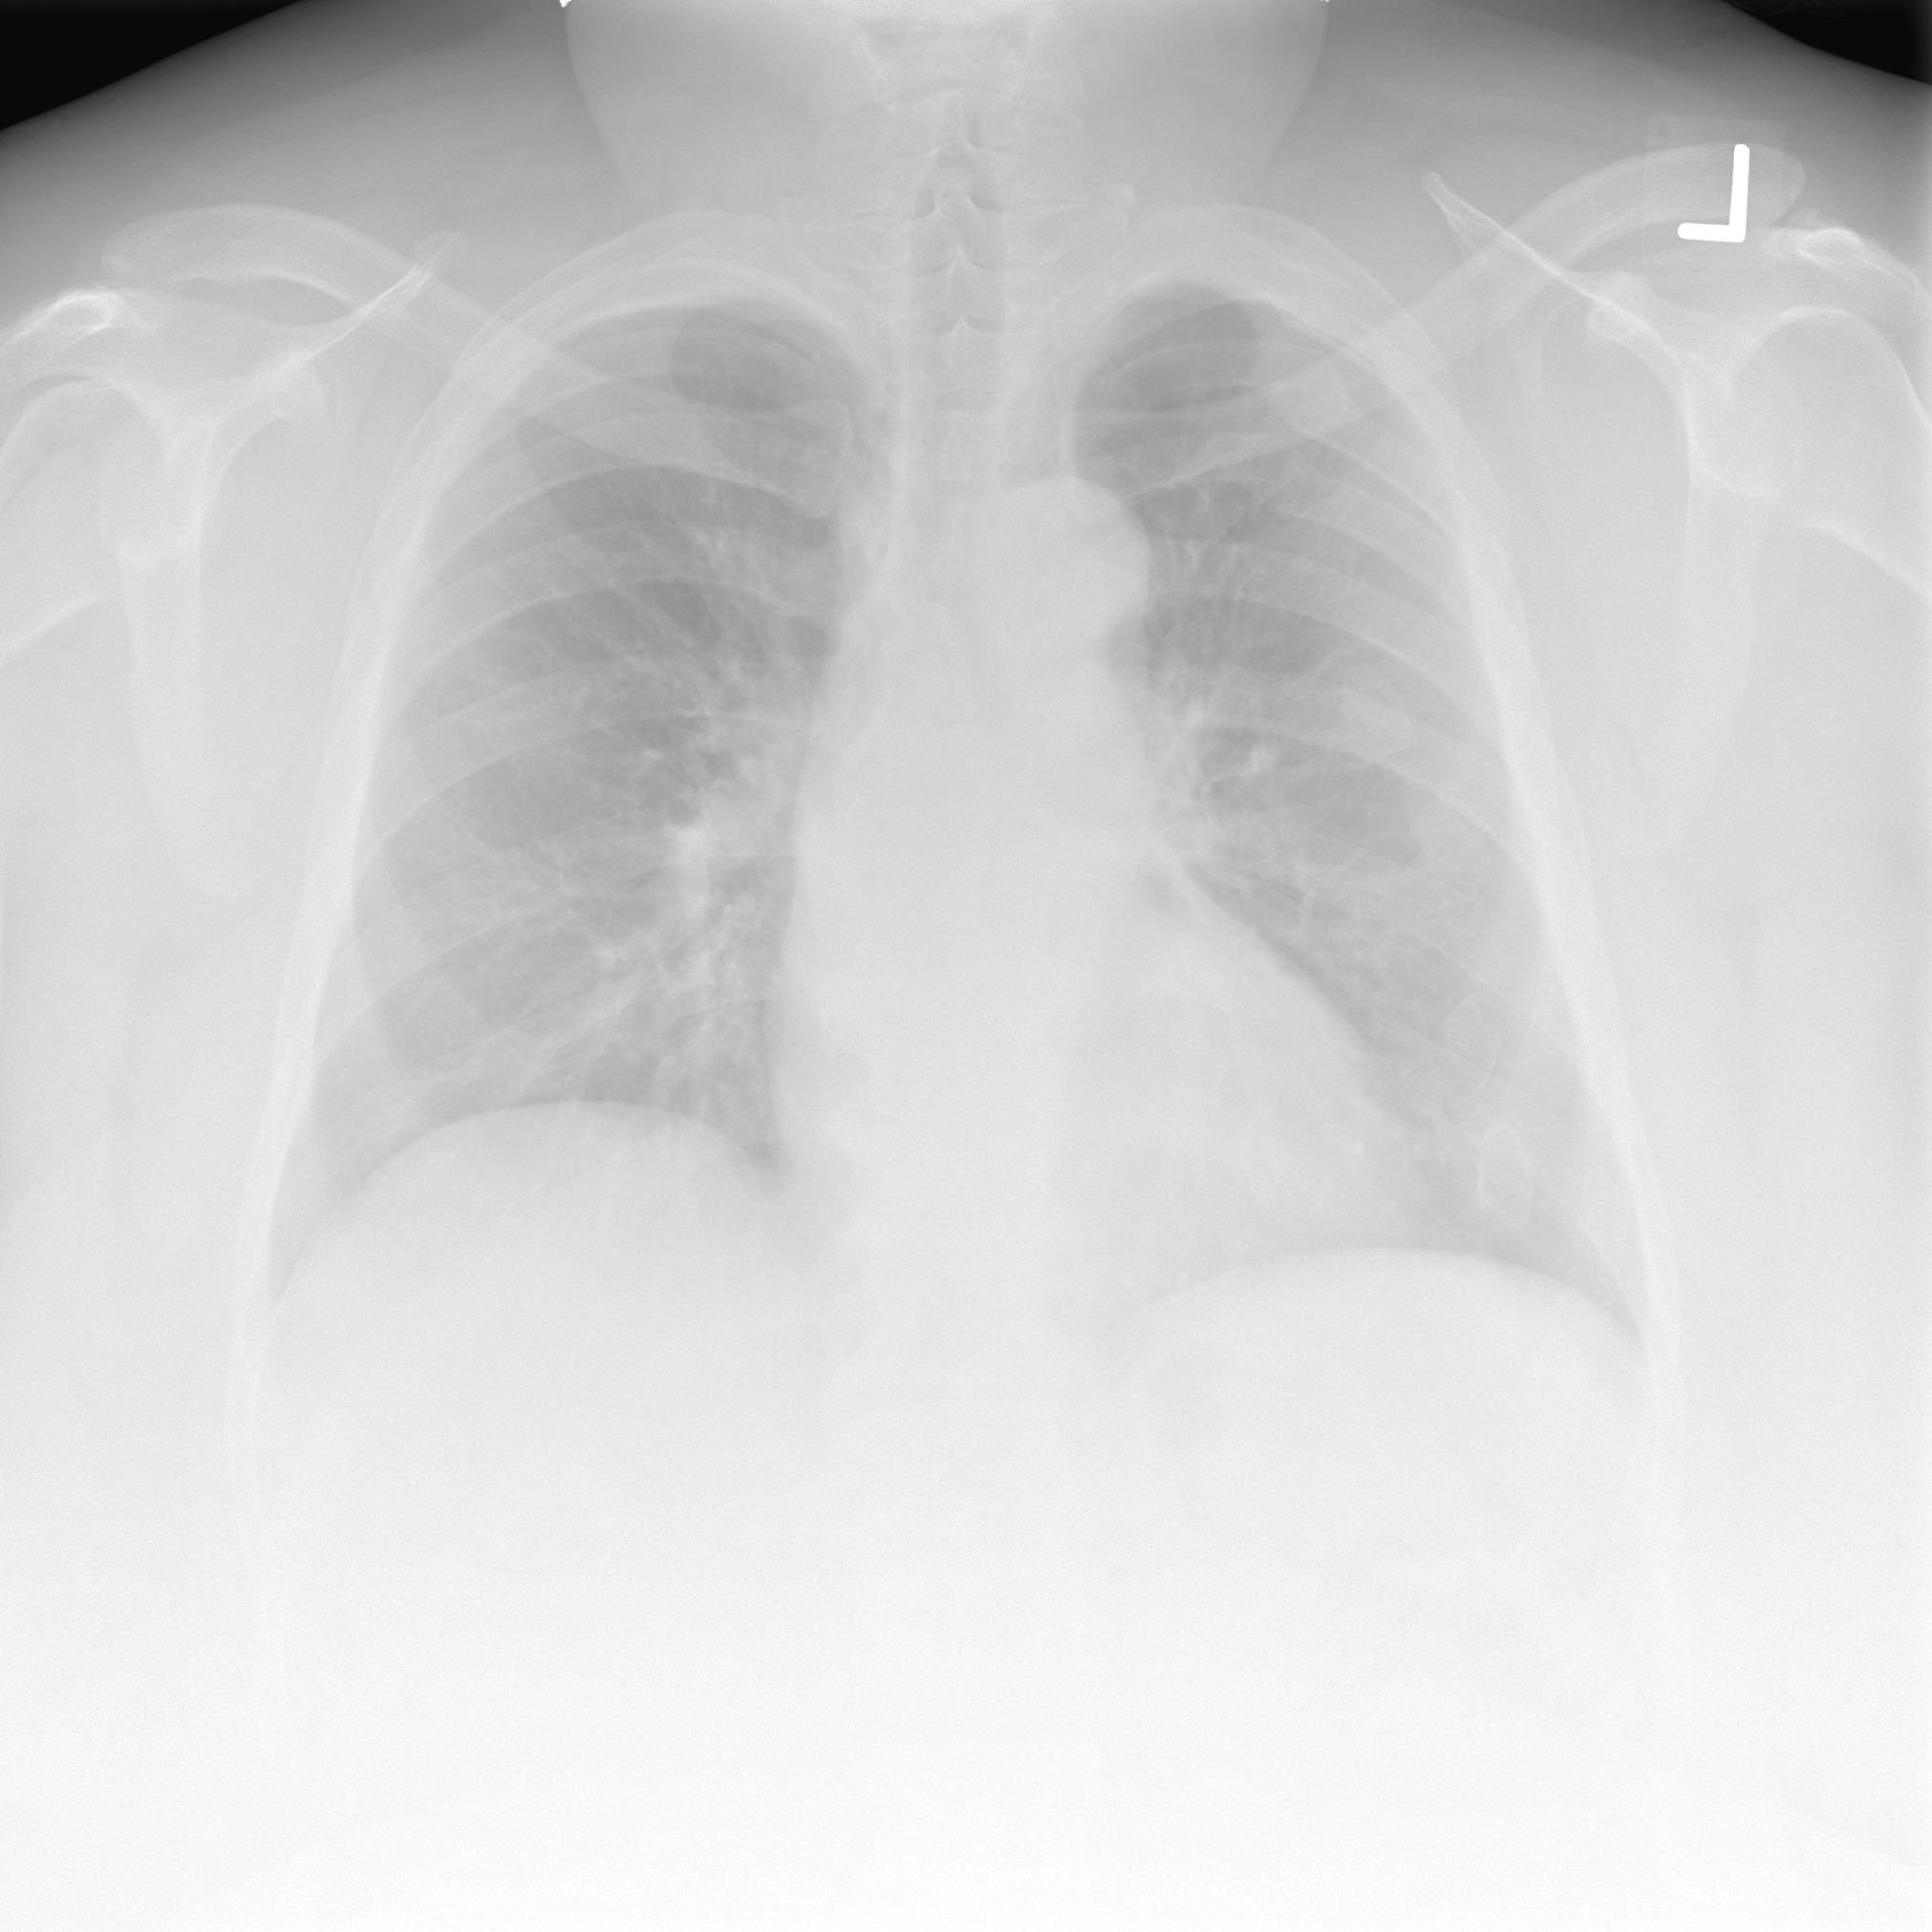

In [628]:
im

In [631]:
im.size

(2048, 2048)

In [630]:
im = im.resize((2048,2048))

In [632]:
im.save('../data/ChestXRay/dataset/images/images_normalized/907_IM-2412-82526002.dcm.png')

In [592]:
2048/im.size[0]

1.003921568627451

In [593]:
im.size[1]*1.003921568627451

2248.7843137254904

In [635]:
importlib.reload(dataset)

<module 'dataset' from '/home/ipmi/code/dataset.py'>

In [639]:

data_set = dataset.build_dataset('train',cfg=cfg)
train_loader = torch.utils.data.DataLoader(
                    data_set, batch_size=32, drop_last=False,
                    shuffle=False, num_workers=8)
it = iter(train_loader)

In [640]:
for i in range(len(train_loader)):
    it.next()
    print(i,end='\r')

In [643]:
train_loader.dataset.vocab_size

1196